# LOADING THE DATA

In [1]:
import psycopg2
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr
from statsmodels.stats.proportion import proportions_ztest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

First I will create the SQL tables that store my data. My data is saved as CSV files and I'll upload them to a Postgre SQL database.

In [2]:
# Establish a connection to PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="odds",
    user="postgres",
    password="postgres",
    port=5432)

print("Connection successful!")

cur = conn.cursor()

cur.execute("SELECT current_database();")
print("Current database:", cur.fetchone()[0])

# Drop tables if they exist
try:
    cur.execute("DROP TABLE IF EXISTS public.bookmakers CASCADE;")
    cur.execute("DROP TABLE IF EXISTS public.games CASCADE;")
except psycopg2.Error as e:
    print(f"Error dropping tables: {e}")

# Games table -- this is the main data table for each game storing the key game features such as the game odds.
create_games_table = """CREATE TABLE IF NOT EXISTS public.games (
                        game_id VARCHAR PRIMARY KEY,
                        home_team VARCHAR,
                        away_team VARCHAR,
                        home_score FLOAT,
                        away_score FLOAT,
                        avg_home_odds FLOAT,
                        avg_draw_odds FLOAT,
                        avg_away_odds FLOAT,
                        high_home_odds FLOAT,
                        high_draw_odds FLOAT,
                        high_away_odds FLOAT,
                        date DATE,
                        sport VARCHAR);"""

# Bookmaker table -- this is the main data table for each bookmaker associated with every game.
create_bookmaker_table = """CREATE TABLE IF NOT EXISTS public.bookmakers (
                            id SERIAL PRIMARY KEY,
                            game_id VARCHAR,
                            bookmaker_name VARCHAR,
                            home_odds FLOAT,
                            draw_odds FLOAT,
                            away_odds FLOAT,
                            FOREIGN KEY (game_id) REFERENCES games(game_id) ON DELETE CASCADE);"""

try:
    cur.execute(create_games_table)
    print("Games table created successfully!")

    cur.execute(create_bookmaker_table)
    print("Bookmakers table created successfully!")

    conn.commit()  # Ensure all changes are saved
except psycopg2.Error as e:
    print(f"Error creating tables: {e}")

cur.close()
conn.close()

print("Tables created successfully.")

Connection successful!
Current database: odds
Games table created successfully!
Bookmakers table created successfully!
Tables created successfully.


Next I will import the data from CSV files into the created SQL Tables.

In [5]:
# List the file paths for each sport
football_game_files = ['/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2013-2014_games.csv',
                       '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2014-2015_games.csv',
                       '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2017-2018_games.csv',
                       '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2018-2019_games.csv',
                       '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2019-2020_games.csv',
                       '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2022-2023_games.csv']

football_bookmaker_files = ['/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2013-2014_bookmakers.csv',
                            '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2014-2015_bookmakers.csv',
                            '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2017-2018_bookmakers.csv',
                            '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2018-2019_bookmakers.csv',
                            '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2019-2020_bookmakers.csv',
                            '/Users/jeffreykang/scrapeOP/football/premier-league/Historical_premier-league_2022-2023_bookmakers.csv']

americanf_game_files = ['/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2013-2014_games.csv',
                        '/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2014-2015_games.csv',
                        '/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2017-2018_games.csv',
                        '/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2019-2020_games.csv',
                        '/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2022-2023_games.csv']

americanf_bookmaker_files = ['/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2013-2014_bookmakers.csv',
                             '/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2014-2015_bookmakers.csv',
                             '/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2017-2018_bookmakers.csv',
                             '/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2019-2020_bookmakers.csv',
                             '/Users/jeffreykang/scrapeOP/american-football/nfl/Historical_nfl_2022-2023_bookmakers.csv']

basketball_game_files = ['/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2014-2015_games.csv',
                         '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2015-2016_games.csv',
                         '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2016-2017_games.csv',
                         '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2017-2018_games.csv',
                         '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2018-2019_games.csv',
                         '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2019-2020_games.csv',
                         '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2020-2021_games.csv',
                         '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2021-2022_games.csv',
                         '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2022-2023_games.csv']

basketball_bookmaker_files = ['/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2014-2015_bookmakers.csv',
                              '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2015-2016_bookmakers.csv',
                              '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2016-2017_bookmakers.csv',
                              '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2017-2018_bookmakers.csv',
                              '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2018-2019_bookmakers.csv',
                              '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2019-2020_bookmakers.csv',
                              '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2020-2021_bookmakers.csv',
                              '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2021-2022_bookmakers.csv',
                              '/Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2022-2023_bookmakers.csv']

In [7]:
# Create a function to load one file for the games SQL Table.
def load_csv_to_game_db(file_path, sport_type):
    data = pd.read_csv(file_path, delimiter=';', header = 0)

    conn = psycopg2.connect(
    host="localhost",
    database="odds",
    user="postgres",
    password="postgres",
    port=5432)

    cur = conn.cursor()

    # Go over each row in the data (csv file).
    for _, row in data.iterrows():
        # Separate soccer from the 2 other sports when loading in draw odds.
        if sport_type in ['american-football','basketball']:
            avg_draw_odds = None
            high_draw_odds = None
        else:
            avg_draw_odds = row['Average Draw Odds']
            high_draw_odds = row['Highest Draw Odds']

        cur.execute(""" INSERT INTO games (
            game_id, home_team, away_team, home_score, away_score, avg_home_odds, avg_draw_odds,
            avg_away_odds, high_home_odds, high_draw_odds, high_away_odds, date, sport) 
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s) """, (
            row['Game ID'], row['Home Team'], row['Away Team'], row['Home Score'], row['Away Score'],
            row['Average Home Odds'], avg_draw_odds, row['Average Away Odds'], row['Highest Home Odds'],
            high_draw_odds, row['Highest Away Odds'], row['Date'], sport_type))

    conn.commit()
    cur.close()
    conn.close()
    print(f'Data from {file_path} imported successfully.')

# Loop over list of files and apply the function.
game_files = basketball_game_files + football_game_files + americanf_game_files

for file in game_files:
    load_csv_to_game_db(file, file.split('scrapeOP/')[1].split('/')[0])

Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2014-2015_games.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2015-2016_games.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2016-2017_games.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2017-2018_games.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2018-2019_games.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2019-2020_games.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2020-2021_games.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2021-2022_games.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2022-2023_games.csv imported successfully.
D

In [9]:
# Create a function that checks for the format of the odds in the data. This cleans up any formatting differences.
def validate_odds(x):
    # Convert the input to a string and strip any surrounding whitespace.
    x_str = str(x).strip()
    # Check if the text contains any numeric characters.
    if re.search(r'\d', x_str):
        # Return the original value if it contains any numbers
        return x  
    else:
        # Replace with None if no numbers are found
        return None  

# Create a function to load one file for the bookmaker SQL Table.
def load_csv_to_bookie_db(file_path, sport_type):
    data = pd.read_csv(file_path, delimiter=';', header = 0)

    conn = psycopg2.connect(
    host="localhost",
    database="odds",
    user="postgres",
    password="postgres",
    port=5432)

    cur = conn.cursor()

    # Identify columns to clean based on the sport type
    if sport_type in ['american-football', 'basketball']:
        odds_columns = ['Home Odds', 'Away Odds']
        # Create a temporary variable for draw odds that will be filled in later.
        draw_odds = None
    else:
        odds_columns = ['Home Odds', 'Draw Odds', 'Away Odds']
        # Same as the condition above
        draw_odds = None  

    # Clean data for all relevant columns using the defined function.
    for col in odds_columns:
        data[col] = data[col].apply(validate_odds)

    # Insert data row by row into the bookmakers SQL table.
    for _, row in data.iterrows():
        if 'Draw Odds' in row:
            # Insert the value of draw odds only if available
            draw_odds = row['Draw Odds']  

        cur.execute(""" INSERT INTO bookmakers (game_id, bookmaker_name, home_odds, draw_odds, away_odds) VALUES (%s, %s, %s, %s, %s) 
        """, (row['Game ID'], row['Bookmaker Name'], row['Home Odds'], draw_odds, row['Away Odds']))

    conn.commit()
    cur.close()
    conn.close()
    print(f'Data from {file_path} imported successfully.')

# Loop over list of files apply the function to load files into the bookmaker SQL database.
bookie_files = basketball_bookmaker_files + football_bookmaker_files + americanf_bookmaker_files

for file in bookie_files:
    load_csv_to_bookie_db(file, file.split('scrapeOP/')[1].split('/')[0])

Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2014-2015_bookmakers.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2015-2016_bookmakers.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2016-2017_bookmakers.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2017-2018_bookmakers.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2018-2019_bookmakers.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2019-2020_bookmakers.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2020-2021_bookmakers.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2021-2022_bookmakers.csv imported successfully.
Data from /Users/jeffreykang/scrapeOP/basketball/nba/Historical_nba_2022

# Preprocessing and Feature Engineering

I'll create some new variables important for the analysis and modeling.
- Season
- Home Team Win (1 if the home team won and 0 if the away team won)
- Odds ratio of Home to Away
- Win Streak (1 or 0) if the previous 3 games were won (resets for every season).
- Loss streak (1 or 0) if the previous 3 games were lost (resets for every season).
- Team Odds Rolling Average for the last 5 games
- Score differential rolling average for the last 5 games
- Historical Team Win Rate @ Home (adjusted for market expectations -- was the home team favored to win?)
- Historical Team Win Rate @ Away (adjusted for market expectations -- was the away team favored to win?)
- Home and Away ELO Ranking based on ELO formula from Australia Sports Tipping website
- Similar Home and Away ELO Team Ratings -- average of the top 2 most similar teams' ELO ratings to represent some cross-sport information
- Average Home and Away Odds Deviation by bookmakers -- for each game, what is the deviation of each bookmakers' odds from the average odds given by OddsPortal

In [11]:
# Let's start by creating a season variable from the game date and sport type
def calculate_season(game_date, sport_type):
    year = game_date.year

    # American football season starts around August and ends by February.
    if sport_type == 'american-football':
        # Before July is the current season
        if game_date.month < 7:  
            return f"{year - 1}-{year}"
        # July or later is the next season
        else: 
            return f"{year}-{year + 1}"

    # Basketball season starts around September and ends by June.
    elif sport_type == 'basketball':
        # Before September is the current season
        if game_date.month < 9:  
            return f"{year - 1}-{year}"
        # After September is the next season
        else:
            return f"{year}-{year + 1}"

    # Soccer season starts around August and ends by May
    elif sport_type == 'football':
        # Before June is the current season
        if game_date.month < 6:
            return f"{year - 1}-{year}"
        # After June is the next season
        else:  
            return f"{year}-{year + 1}"
    
    else:
        raise ValueError("Invalid sport type!")

conn = psycopg2.connect(
    host="localhost",
    database="odds",
    user="postgres",
    password="postgres",
    port=5432)

cur = conn.cursor()

cur.execute("ALTER TABLE public.games ADD COLUMN season VARCHAR;")
cur.execute("SELECT game_id, date, sport FROM games;")
games = cur.fetchall()

# Loop through the games and calculate the season 
for game_id, date, sport in games:
    season = calculate_season(date, sport)
    cur.execute("""UPDATE games SET season = %s WHERE game_id = %s;""", (season, game_id))

conn.commit()
cur.close()
conn.close()
print("Season column populated successfully!")

Season column populated successfully!


In [13]:
# Create columns in the games database to account for the additional features
conn = psycopg2.connect(
    host="localhost",
    database="odds",
    user="postgres",
    password="postgres",
    port=5432)

cur = conn.cursor()

# Adding the additional features
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS avg_odds_ratio FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS high_odds_ratio FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS hteam_w_streak INT DEFAULT 0;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS ateam_w_streak INT DEFAULT 0;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS hteam_l_streak INT DEFAULT 0;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS ateam_l_streak INT DEFAULT 0;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS hteam_win FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS roll_avg_home_odds FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS roll_avg_away_odds FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS roll_high_home_odds FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS roll_high_away_odds FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS upset FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS home_wr_favored FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS away_wr_favored FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS home_wr_underdog FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS away_wr_underdog FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS roll_home_scorediff FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS roll_away_scorediff FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS home_team_elo FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS away_team_elo FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS sim_home_team_elo FLOAT;")
cur.execute("ALTER TABLE games ADD COLUMN IF NOT EXISTS sim_away_team_elo FLOAT;")

cur.execute("""SELECT game_id, sport, season, date, home_team, away_team, home_score, away_score,
                      avg_home_odds, avg_away_odds, high_home_odds, high_away_odds
               FROM games ORDER BY season, date;""")
games = cur.fetchall()

cur.execute("""SELECT game_id, bookmaker_name, home_odds, draw_odds, away_odds FROM bookmakers""")
bookmakers = cur.fetchall()

# Commit the changes and close the connection
conn.commit()
cur.close()
conn.close()

The code below calculates these features and adds them to the databases: games and bookies.

In [15]:
# First retrieve the games data frame
df = pd.DataFrame(games, columns=['game_id', 'sport', 'season', 'date', 'home_team', 'away_team', 'home_score', 
                                  'away_score', 'avg_home_odds', 'avg_away_odds', 'high_home_odds', 'high_away_odds'])

# Calculate adjusted odds ratio. If the odds have mixed signs, then take the ratio of the abs value for both.
# Else, directly take the ratio
def adjusted_odds_ratio(home_odds, away_odds):
    if (home_odds > 0 and away_odds < 0) or (home_odds < 0 and away_odds > 0):
        # Mixed-sign case: take the absolute value ratio
        return abs(home_odds) / abs(away_odds)
    else:
        # Same-sign case: keep the ratio as it is
        return home_odds / away_odds

df['avg_odds_ratio'] = df.apply(
    lambda row: adjusted_odds_ratio(row['avg_home_odds'], row['avg_away_odds']), axis=1)
df['high_odds_ratio'] = df.apply(
    lambda row: adjusted_odds_ratio(row['high_home_odds'], row['high_away_odds']), axis=1)

###
# Calculate ELO Ratings
# Constants
initial_elo = 1500
home_advantage = 100
k_factor = 20  # Base K-factor

# Function to calculate expected score
def expected_score(team_elo, opponent_elo, home_team=False):
    dr = team_elo - opponent_elo + (home_advantage if home_team else 0)
    return 1 / (1 + 10 ** (-dr / 400))

# Function to calculate G (margin of victory multiplier)
def calculate_g(pointdiff, sport, winner_elo, loser_elo):
    if sport == "basketball":
        return ((pointdiff + 3) ** 0.8) / (7.5 + 0.006 * (winner_elo - loser_elo + home_advantage))
    elif sport == "american-football":
        return np.log(1 + pointdiff) * 2.2 / ((winner_elo - loser_elo) * 0.001 + 2.2)
    elif sport == "football":
        if pointdiff == 1:
            return 1
        elif pointdiff == 2:
            return 1.5
        elif pointdiff == 3:
            return 1.75
        else:
            return (11 + pointdiff) / 8
    else:
        raise ValueError("Sport not recognized for G calculation")

# Function to update Elo ratings
def update_elo(team_elo, opponent_elo, outcome, pointdiff, sport, home_team=False):
    expected = expected_score(team_elo, opponent_elo, home_team=home_team)
    if outcome == 1:  # Team wins
        winner_elo, loser_elo = team_elo, opponent_elo
    else:  # Team loses
        winner_elo, loser_elo = opponent_elo, team_elo

    g = calculate_g(pointdiff, sport, winner_elo, loser_elo)
    k_adjusted = k_factor * g
    delta = k_adjusted * (outcome - expected)
    return team_elo + delta

# Initialize Elo ratings for all teams
all_teams = df['home_team'].unique().tolist() + df['away_team'].unique().tolist()
elo_ratings = {team: initial_elo for team in all_teams}

# Columns to store Elo ratings
df['home_team_elo'] = None
df['away_team_elo'] = None

# Iterate through the DataFrame to calculate Elo ratings
for index, row in df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    sport = row['sport'] 
    home_score = row['home_score']
    away_score = row['away_score']
    pointdiff = abs(home_score - away_score)
    outcome = 1 if home_score > away_score else 0

    # Get current Elo ratings
    home_team_elo = elo_ratings[home_team]
    away_team_elo = elo_ratings[away_team]

    # Update Elo ratings
    elo_ratings[home_team] = update_elo(home_team_elo, away_team_elo, outcome, pointdiff, sport, home_team=True)
    elo_ratings[away_team] = update_elo(away_team_elo, home_team_elo, 1 - outcome, pointdiff, sport, home_team=False)

    # Record updated ratings in DataFrame
    df.at[index, 'home_team_elo'] = elo_ratings[home_team]
    df.at[index, 'away_team_elo'] = elo_ratings[away_team]

###
# Define function for determining home team win, which will be 1 if the home team won and 0 if the away team won
# Also I'll track the winning team and create a variable to determine upset, which is when the team (home or away) won but was not favored
def determine_winner(row):
    if row['home_score'] > row['away_score']:
        winner = row['home_team']
        home_team_win = 1
    elif row['away_score'] > row['home_score']:
        winner = row['away_team']
        home_team_win = 0
    else:
        return None, None, None
    upset = int((row['avg_home_odds'] < row['avg_away_odds'] and home_team_win == 0) or
                (row['avg_away_odds'] < row['avg_home_odds'] and home_team_win == 1))
    return winner, home_team_win, upset

df[['winner', 'home_team_win', 'upset']] = df.apply(determine_winner, axis=1, result_type='expand')

### 
# Initialize tracker dictionaries for win/loss streaks and rolling averages. This will use a team_tracker that tracks the team as well.
win_tracker, loss_tracker, team_tracker, hteam_tracker, ateam_tracker = {}, {}, {}, {}, {}

# Calculate mean and std of score diff by each sport for standardization
df['home_score_diff'] = df['home_score'] - df['away_score']
df['away_score_diff'] = df['away_score'] - df['home_score']
home_score_diff_stats = df.groupby('sport')['home_score_diff'].agg(['mean', 'std']).to_dict('index')
away_score_diff_stats = df.groupby('sport')['away_score_diff'].agg(['mean', 'std']).to_dict('index')

# Loop by season to find win/loss streaks, and rolling averages
current_season = None
for index, row in df.iterrows():
    if row['season'] != current_season:
        current_season = row['season']
        # Reset the trackers for every season.
        win_tracker, loss_tracker, team_tracker, hteam_tracker, ateam_tracker = {}, {}, {}, {}, {}

    home_team, away_team = row['home_team'], row['away_team']
    home_score, away_score = row['home_score'], row['away_score']
    home_score_diff = home_score - away_score
    away_score_diff = away_score - home_score
    sport = row.get('sport')

    # Add the home and away teams to the trackers win/loss streaks and rolling averages
    for team in [home_team, away_team]:
        if team not in win_tracker:
            win_tracker[team], loss_tracker[team] = {'streak': 0, 'streak_flag': 0}, {'streak': 0, 'streak_flag': 0}

    # Add home and away teams to home and away team trackers
    if home_team not in hteam_tracker:
        hteam_tracker[home_team] = {'avg_odds': [], 'high_odds': [], 'score_diffs': []}
    if away_team not in ateam_tracker:
        ateam_tracker[away_team] = {'avg_odds': [], 'high_odds': [], 'score_diffs': []}
    
    # Update score differentials, rolling odds, and streak flags
    hteam_tracker[home_team]['avg_odds'].append(row['avg_home_odds'])
    ateam_tracker[away_team]['avg_odds'].append(row['avg_away_odds'])
    hteam_tracker[home_team]['high_odds'].append(row['high_home_odds'])
    ateam_tracker[away_team]['high_odds'].append(row['high_away_odds'])
    hteam_tracker[home_team]['score_diffs'].append(home_score_diff)
    ateam_tracker[away_team]['score_diffs'].append(away_score_diff)

    # Computes the mean for the rolling score differential
    roll_home_score_diff = pd.Series(hteam_tracker[home_team]['score_diffs'][-5:]).mean()
    roll_away_score_diff = pd.Series(ateam_tracker[away_team]['score_diffs'][-5:]).mean()
    # Since the sports have different scores magnitudes, I'll then standardize the score differentials by each sport
    home_sport_mean = home_score_diff_stats[sport]['mean']
    home_sport_std = home_score_diff_stats[sport]['std']
    away_sport_mean = away_score_diff_stats[sport]['mean']
    away_sport_std = away_score_diff_stats[sport]['std']

    standardized_roll_home_diff = (roll_home_score_diff - home_sport_mean) / home_sport_std 
    standardized_roll_away_diff = (roll_away_score_diff - away_sport_mean) / away_sport_std 

    # Computes the mean for the last 5 values of the team in the team_tracker dictionary for the specific variables
    df.at[index, 'roll_home_score_diff'] = standardized_roll_home_diff
    df.at[index, 'roll_away_score_diff'] = standardized_roll_away_diff
    df.at[index, 'roll_avg_home_odds'] = pd.Series(hteam_tracker[home_team]['avg_odds'][-5:]).mean()
    df.at[index, 'roll_avg_away_odds'] = pd.Series(ateam_tracker[away_team]['avg_odds'][-5:]).mean()
    df.at[index, 'roll_high_home_odds'] = pd.Series(hteam_tracker[home_team]['high_odds'][-5:]).mean()
    df.at[index, 'roll_high_away_odds'] = pd.Series(ateam_tracker[away_team]['high_odds'][-5:]).mean()

    # Set streak flags in DataFrame for current row (or game)
    df.at[index, 'home_team_w_streak'] = win_tracker[home_team]['streak_flag']
    df.at[index, 'away_team_w_streak'] = win_tracker[away_team]['streak_flag']
    df.at[index, 'home_team_l_streak'] = loss_tracker[home_team]['streak_flag']
    df.at[index, 'away_team_l_streak'] = loss_tracker[away_team]['streak_flag']

    # Update win/loss streaks based on the winner and loser
    if row['winner']:
        win_tracker[row['winner']]['streak'] += 1
        win_tracker[row['winner']]['streak_flag'] = 1 if win_tracker[row['winner']]['streak'] >= 3 else 0
        loss_tracker[row['winner']] = {'streak': 0, 'streak_flag': 0}

        # - Reset the winning streak for the losing team.
        # - Increment the losing streak for the losing team and set the 'streak_flag' to 1 if the streak reaches or exceeds 3 losses.
        loser = away_team if row['winner'] == home_team else home_team
        win_tracker[loser], loss_tracker[loser] = {'streak': 0, 'streak_flag': 0}, {'streak': loss_tracker[loser]['streak'] + 1, 'streak_flag': 1 if loss_tracker[loser]['streak'] >= 3 else 0}

# Calculating an "adjusted" historical win rate based on if the home/away team was favored and if the team won
# This is because a normal historical win rate or historical implied probability doesn't account for the game nuances
df['home_team_favored'] = df['avg_home_odds'] < df['avg_away_odds']
df['away_team_favored'] = df['avg_away_odds'] < df['avg_home_odds']
df['favored'] = df.apply(
    lambda row: 'home' if row['home_team_favored'] 
    else ('away' if row['away_team_favored'] else 'none'), 
    axis=1)
home_wr_favored = df[df['favored'] == 'home'].groupby('home_team')['home_team_win'].mean()
away_wr_favored = df[df['favored'] == 'away'].groupby('away_team')['home_team_win'].mean()
home_wr_underdog = df[df['favored'] == 'away'].groupby('home_team')['home_team_win'].mean()
away_wr_underdog = df[df['favored'] == 'home'].groupby('away_team')['home_team_win'].mean()
df['home_wr_favored'] = df['home_team'].map(home_wr_favored).fillna(0)
df['away_wr_favored'] = df['away_team'].map(away_wr_favored).fillna(0)
df['home_wr_underdog'] = df['home_team'].map(home_wr_underdog).fillna(0)
df['away_wr_underdog'] = df['away_team'].map(away_wr_underdog).fillna(0)

# win_rate_favored = df[df['favored'] == 'home'].groupby('home_team')['home_team_win'].mean() 
# win_rate_underdog = df[df['favored'] == 'away'].groupby('away_team')['home_team_win'].mean()
# home_games = df['home_team'].value_counts()
# away_games = df['away_team'].value_counts()
# total_games = home_games.add(away_games, fill_value=0)
# favored_proportion_home = df[df['favored'] == 'home'].groupby('home_team').size() / total_games
# favored_proportion_away = df[df['favored'] == 'away'].groupby('away_team').size() / total_games
# underdog_proportion_home = 1 - favored_proportion_home 
# underdog_proportion_away = 1 - favored_proportion_away
# adjusted_historical_win_rate_home = (win_rate_favored * favored_proportion_home + win_rate_underdog * underdog_proportion_home).fillna(0)
# adjusted_historical_win_rate_away = (win_rate_favored * favored_proportion_away + win_rate_underdog * underdog_proportion_away).fillna(0)
# df['adj_hwr_home'] = df['home_team'].map(adjusted_historical_win_rate_home)
# df['adj_hwr_away'] = df['away_team'].map(adjusted_historical_win_rate_away)

###
# Calculating a similarity score based on features
# Define a function to find the most similar teams based on key features
similar_features_home = ['home_team_elo', 'roll_home_score_diff', 'home_team_w_streak','home_team_l_streak','home_wr_favored',
                        'home_wr_underdog','home_team_win', 'roll_avg_home_odds', 'roll_high_home_odds']
similar_features_away = ['away_team_elo', 'roll_away_score_diff', 'away_team_w_streak','away_team_l_streak','away_wr_favored',
                        'away_wr_underdog','home_team_win', 'roll_avg_away_odds', 'roll_high_away_odds']

# Impute mean for 'roll_avg_home_odds' and 'roll_avg_away_odds' without using inplace=True
df = df.assign(
    roll_avg_home_odds=df['roll_avg_home_odds'].fillna(df['roll_avg_home_odds'].mean()),
    roll_avg_away_odds=df['roll_avg_away_odds'].fillna(df['roll_avg_away_odds'].mean()),
    roll_high_home_odds=df['roll_high_home_odds'].fillna(df['roll_high_home_odds'].mean()),
    roll_high_away_odds=df['roll_high_away_odds'].fillna(df['roll_high_away_odds'].mean()))

# Drop rows with NaN in 'upset' and 'home_team_win'
df = df.dropna(subset=['upset', 'home_team_win','avg_home_odds','avg_away_odds','high_home_odds','high_away_odds'])

def find_similar_teams(target_team, target_sport, df, num_similar=2, elo_column='home_team_elo'):
    # Check if the team is a home or away team and set relevant features
    if elo_column == 'home_team_elo':
        target_features = df[(df['home_team'] == target_team) & (df['sport'] == target_sport)][similar_features_home].values
        other_teams = df[(df['sport'] != target_sport) & (df['home_team'] != target_team)].reset_index()
        other_team_features = other_teams[similar_features_home].values
    else: 
        target_features = df[(df['away_team'] == target_team) & (df['sport'] == target_sport)][similar_features_away].values
        other_teams = df[(df['sport'] != target_sport) & (df['away_team'] != target_team)].reset_index()
        other_team_features = other_teams[similar_features_away].values

    # Standardize the key features
    scaler = StandardScaler()
    target_features_scaled = scaler.fit_transform(target_features)
    other_team_features_scaled = scaler.transform(other_team_features)

    # Calculate cosine similarity between the target team and all other teams in different sports
    similarity_scores = cosine_similarity(target_features_scaled, other_team_features_scaled)

    # Get the index of the highest similarity teams
    most_similar_indices = np.argsort(similarity_scores[0])[-num_similar:][::-1]
    
    # Retrieve the most similar teams based on the highest similarity index
    most_similar_teams = other_teams.iloc[most_similar_indices]['home_team' if elo_column == 'home_team_elo' else 'away_team'].tolist()
    
    return most_similar_teams

# For each season, calculate the similar team metrics.
for season in df['season'].unique():
    season_df = df[df['season'] == season]
    
    for index, game in season_df.iterrows():
        home_team = game['home_team']
        away_team = game['away_team']
        sport = game['sport'] 

        # Find similar teams for the home and away teams using appropriate Elo columns
        similar_home_teams = find_similar_teams(home_team, sport, season_df, num_similar=2, elo_column='home_team_elo')
        similar_away_teams = find_similar_teams(away_team, sport, season_df, num_similar=2, elo_column='away_team_elo')
        
        similar_home_team_elos = df[(df['home_team'].isin(similar_home_teams)) & (df['home_team'] != home_team)]['home_team_elo']
        similar_away_team_elos = df[(df['away_team'].isin(similar_away_teams)) & (df['away_team'] != away_team)]['away_team_elo']

        # Calculate the mean Elo ratings for the similar teams if available, else use NaN
        similar_home_team_elo = similar_home_team_elos.mean() if not similar_home_team_elos.empty else np.nan
        similar_away_team_elo = similar_away_team_elos.mean() if not similar_away_team_elos.empty else np.nan

        # Update the DataFrame with the new features
        df.at[index, 'sim_home_team_elo'] = similar_home_team_elo
        df.at[index, 'sim_away_team_elo'] = similar_away_team_elo

###
# Now update the SQL table for the processed variables
conn = psycopg2.connect(
    host="localhost",
    database="odds",
    user="postgres",
    password="postgres",
    port=5432)

cur = conn.cursor()

for _, row in df.iterrows():
    cur.execute("""UPDATE games SET hteam_w_streak = %s, ateam_w_streak = %s, hteam_l_streak = %s, ateam_l_streak = %s,
    hteam_win = %s, upset = %s, roll_avg_home_odds = %s, roll_avg_away_odds = %s, roll_high_home_odds = %s, 
    roll_high_away_odds = %s, avg_odds_ratio = %s, high_odds_ratio = %s, home_wr_favored = %s, away_wr_favored = %s, home_wr_underdog = %s, away_wr_underdog = %s, 
    roll_home_scorediff = %s, roll_away_scorediff = %s, home_team_elo = %s, away_team_elo = %s, sim_home_team_elo = %s, sim_away_team_elo = %s WHERE game_id = %s;""", 
                (row['home_team_w_streak'], row['away_team_w_streak'],row['home_team_l_streak'],row['away_team_l_streak'],
                 row['home_team_win'], row['upset'],row['roll_avg_home_odds'], row['roll_avg_away_odds'], row['roll_high_home_odds'], 
                 row['roll_high_away_odds'], row['avg_odds_ratio'], row['high_odds_ratio'], row['home_wr_favored'], row['away_wr_favored'], row['home_wr_underdog'], 
                 row['away_wr_underdog'], row['roll_home_score_diff'], row['roll_away_score_diff'], row['home_team_elo'], row['away_team_elo'], 
                 row['sim_home_team_elo'], row['sim_away_team_elo'], row['game_id']))
conn.commit()
print("Games table updated")
cur.close()
conn.close()

Games table updated


### Average Odds Deviation by Bookmakers

Index(['game_id', 'home_team', 'away_team', 'home_score', 'away_score',
       'avg_home_odds', 'avg_draw_odds', 'avg_away_odds', 'high_home_odds',
       'high_draw_odds', 'high_away_odds', 'date', 'sport', 'season',
       'avg_odds_ratio', 'high_odds_ratio', 'hteam_w_streak', 'ateam_w_streak',
       'hteam_l_streak', 'ateam_l_streak', 'hteam_win', 'roll_avg_home_odds',
       'roll_avg_away_odds', 'roll_high_home_odds', 'roll_high_away_odds',
       'upset', 'home_wr_favored', 'away_wr_favored', 'home_wr_underdog',
       'away_wr_underdog', 'roll_home_scorediff', 'roll_away_scorediff',
       'home_team_elo', 'away_team_elo', 'sim_home_team_elo',
       'sim_away_team_elo', 'bookmaker_name', 'home_odds', 'draw_odds',
       'away_odds', 'game_dev_home_odds', 'game_dev_away_odds',
       'game_dev_draw_odds'],
      dtype='object')
(157859, 43)
      game_dev_home_odds  game_dev_away_odds  game_dev_draw_odds
mean           -4.930794           -0.844018            0.102749
min      

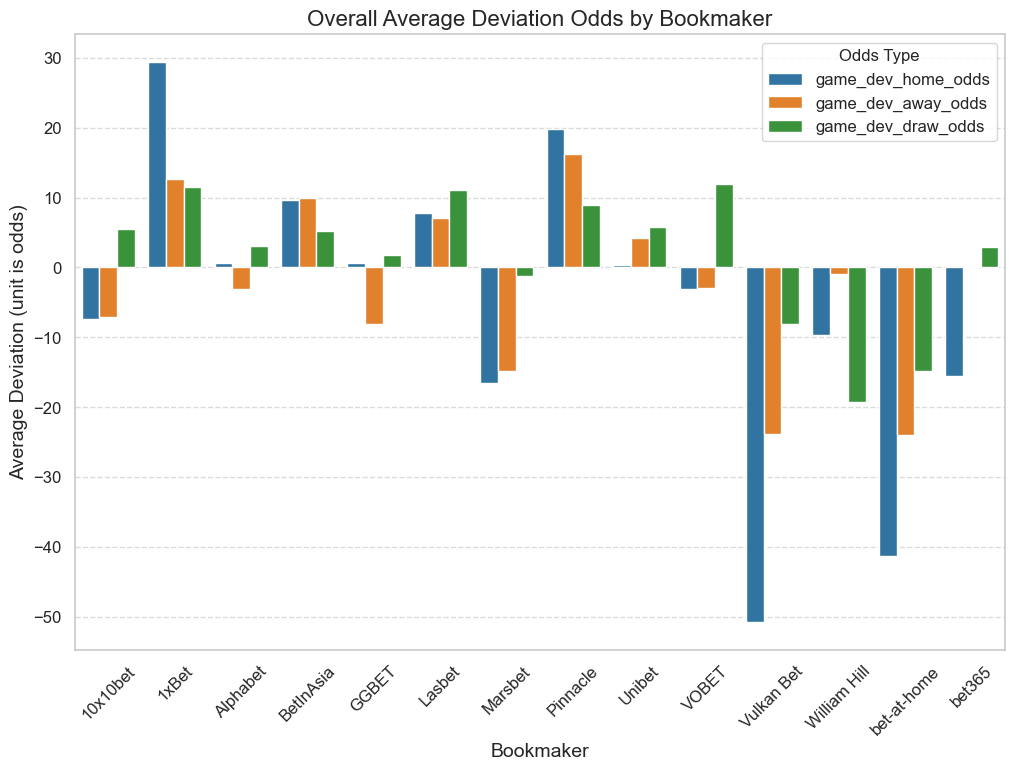

Summary statistics for american-football:
               sport game_dev_home_odds                            \
                                   mean     min     max       std   
0  american-football          -2.083708 -3333.0  3000.0  64.89637   

  game_dev_away_odds                          game_dev_draw_odds              
                mean    min    max        std               mean min max std  
0          -0.466469 -938.0  443.0  37.182046                NaN NaN NaN NaN  


Summary statistics for basketball:
        sport game_dev_home_odds                              \
                            mean     min     max         std   
1  basketball          -7.583769 -7586.0  8333.0  206.093791   

  game_dev_away_odds                            game_dev_draw_odds              
                mean     min     max        std               mean min max std  
1          -1.230643 -6667.0  3334.0  69.931356                NaN NaN NaN NaN  


Summary statistics for football:
     

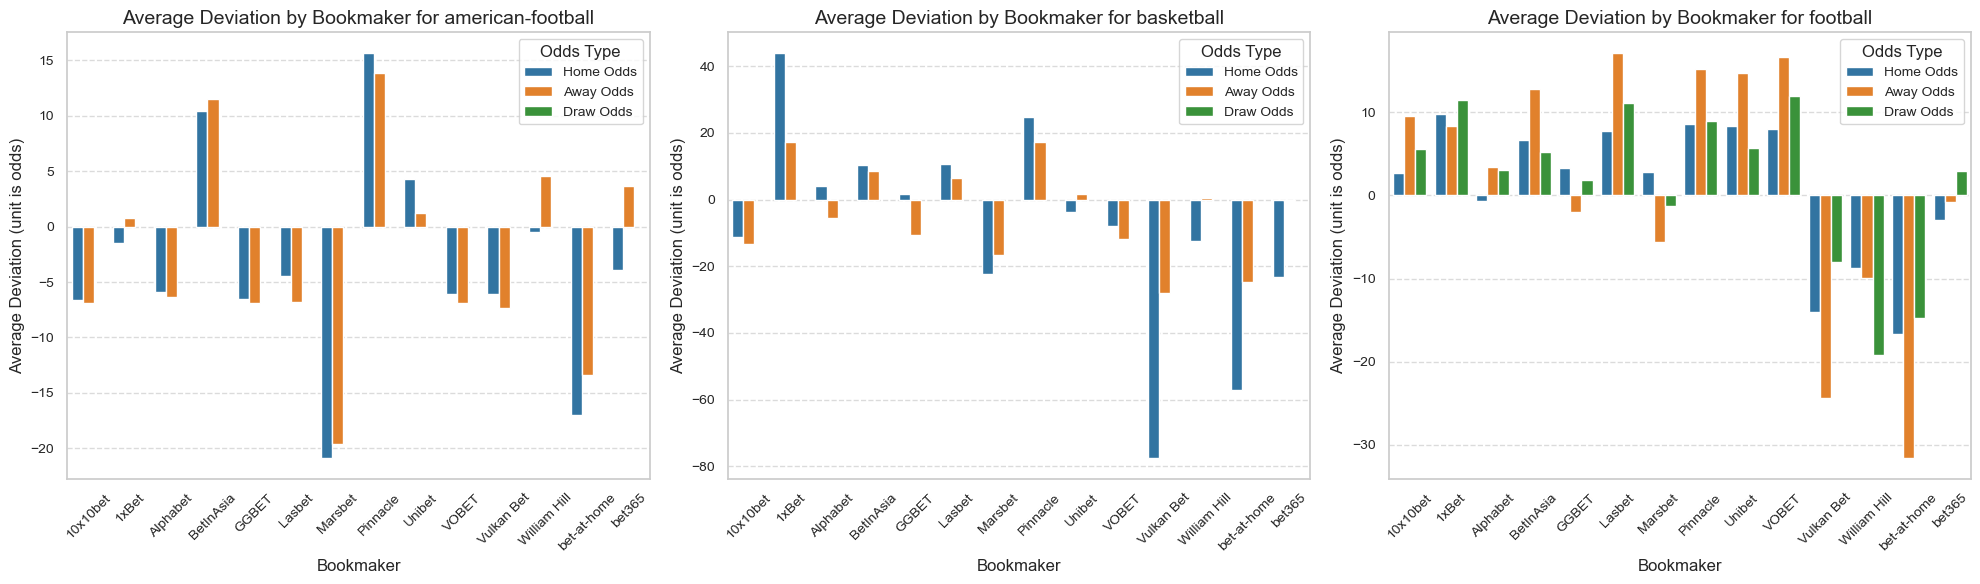

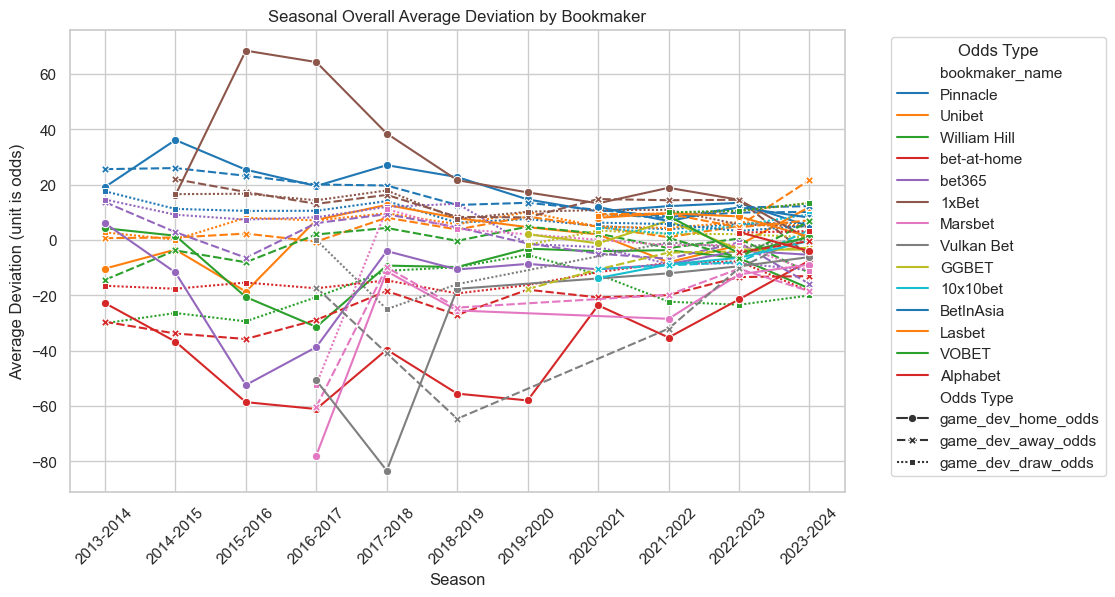

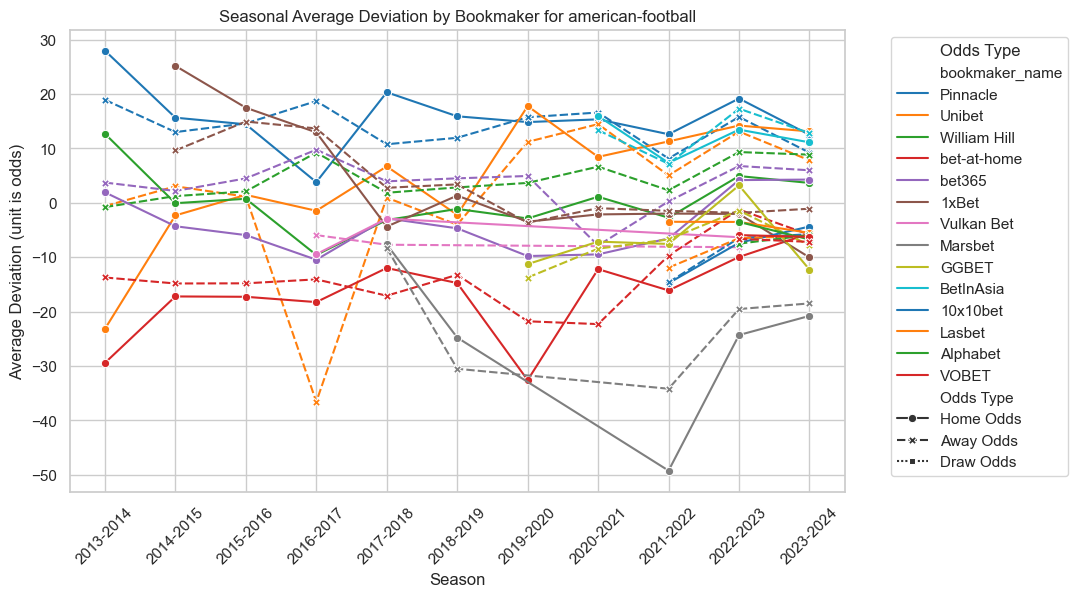

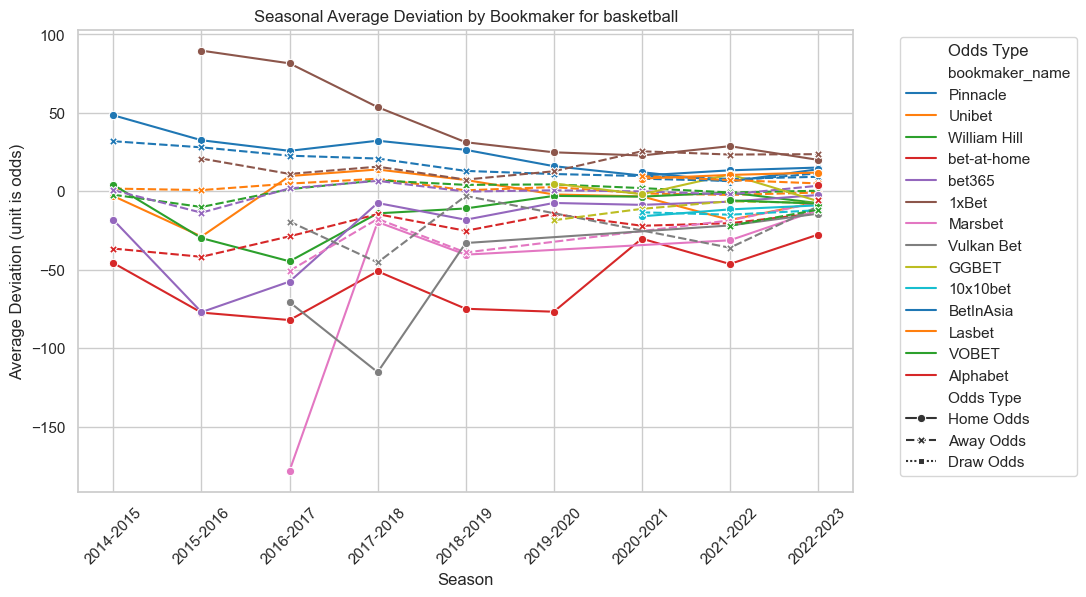

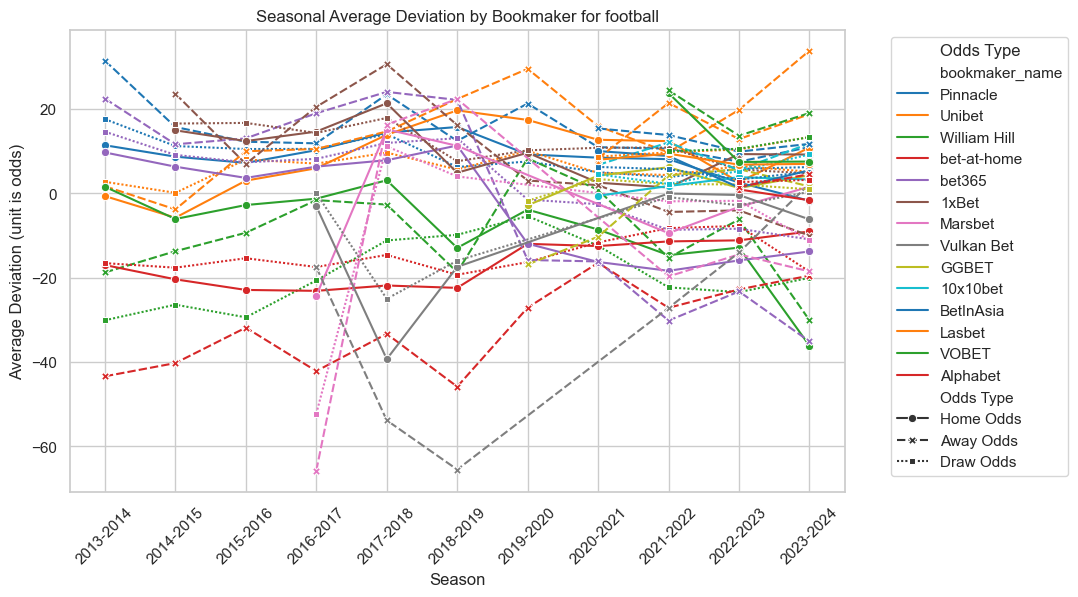

In [17]:
# I'll find the mean deviation for each game and then find the mean deviation for the season and then for the sport
conn = psycopg2.connect(
    host="localhost",
    database="odds",
    user="postgres",
    password="postgres",
    port=5432)

query = """WITH game_deviations AS (SELECT g.*, b.bookmaker_name, b.home_odds, b.draw_odds, b.away_odds,
        (b.home_odds - g.avg_home_odds) AS game_dev_home_odds,
        (b.away_odds - g.avg_away_odds) AS game_dev_away_odds,
        CASE
            WHEN g.sport = 'football' THEN (b.draw_odds - g.avg_draw_odds)
            ELSE NULL
        END AS game_dev_draw_odds
    FROM 
        games g
    JOIN 
        bookmakers b ON g.game_id = b.game_id) SELECT * FROM game_deviations
ORDER BY 
    sport, season, bookmaker_name;
"""

with conn.cursor() as cur:
    cur.execute(query)
    columns = [desc[0] for desc in cur.description]  
    results = cur.fetchall() 

conn.close()

# Create the main dataframe to be used in the modeling
deviations_df = pd.DataFrame(results, columns=columns)

# Remove rows where 'bookmaker_name' is NaN
deviations_df = deviations_df[deviations_df['bookmaker_name'] != 'NaN']

print(deviations_df.columns)

# Print the size of this df
print(deviations_df.shape)

# Compute summary stats for the bookmaker deviation before plotting
overall_stats = deviations_df[['game_dev_home_odds', 'game_dev_away_odds', 'game_dev_draw_odds']].agg(['mean', 'min', 'max', 'std'])
print(overall_stats)

# Set custom colors: Blue, Orange, Green
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 
# Set the background with a gridline
sns.set_theme(style="whitegrid")

# Group by bookmaker and calculate mean deviations for each odds type
overall_deviation = deviations_df.groupby('bookmaker_name')[['game_dev_home_odds', 'game_dev_away_odds', 'game_dev_draw_odds']].mean().reset_index()

melted_data = overall_deviation.melt(id_vars='bookmaker_name', var_name='Odds Type', value_name='Deviation')
plt.figure(figsize=(12, 8))
sns.barplot(
    data=melted_data, 
    x='bookmaker_name', 
    y='Deviation', 
    hue='Odds Type', 
    palette=colors)
plt.title('Overall Average Deviation Odds by Bookmaker', fontsize=16)
plt.xlabel('Bookmaker', fontsize=14)
plt.ylabel('Average Deviation (unit is odds)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Odds Type', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("overall_deviation_bookmaker.png", dpi=300, bbox_inches='tight')
plt.show()

# Compute summary stats for each sport for average bookmaker deviation
sport_summary_stats = (deviations_df.groupby('sport')[['game_dev_home_odds', 'game_dev_away_odds', 'game_dev_draw_odds']].agg(['mean', 'min', 'max', 'std']).reset_index())

for sport in sport_summary_stats['sport'].unique():
    print(f"Summary statistics for {sport}:")
    sport_stats = sport_summary_stats[sport_summary_stats['sport'] == sport]
    print(sport_stats)
    print("\n")

# Calculate deviations grouped by sport and bookmaker
sport_deviations = deviations_df.groupby(['sport', 'bookmaker_name'])[['game_dev_home_odds', 'game_dev_away_odds', 'game_dev_draw_odds']].mean().reset_index()
# Rename the columns for better readability
sport_deviations = sport_deviations.rename(columns={
    'game_dev_home_odds': 'Home Odds',
    'game_dev_away_odds': 'Away Odds',
    'game_dev_draw_odds': 'Draw Odds'})

# Create a 1x3 subplot for the 3 sports
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Adjust width and height as needed
unique_sports = sport_deviations['sport'].unique()
for i, sport in enumerate(unique_sports):
    sport_data = sport_deviations[sport_deviations['sport'] == sport]
    melted_data = sport_data.melt(
        id_vars=['sport', 'bookmaker_name'],
        var_name='Odds Type',
        value_name='Deviation')
    sns.barplot(
        data=melted_data,
        x='bookmaker_name',
        y='Deviation',
        hue='Odds Type',
        ax=axes[i],
        palette=colors)
    axes[i].set_title(f'Average Deviation by Bookmaker for {sport}', fontsize=14)
    axes[i].set_xlabel('Bookmaker', fontsize=12)
    axes[i].set_ylabel('Average Deviation (unit is odds)', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].legend(title='Odds Type', fontsize=10)
plt.tight_layout()
plt.savefig("grid_deviation_bookmakers.png", dpi=300, bbox_inches='tight')
plt.show()

# Now to plot the deviation by each bookmaker across seasons
season_deviations = deviations_df.groupby(['season', 'bookmaker_name'])[['game_dev_home_odds', 'game_dev_away_odds', 'game_dev_draw_odds']].mean().reset_index()
sseason_deviations = season_deviations.rename(columns={'game_dev_home_odds': 'Home Odds','game_dev_away_odds': 'Away Odds','game_dev_draw_odds': 'Draw Odds'})
season_deviations = season_deviations[season_deviations['bookmaker_name'] != 'NaN']
palette = sns.color_palette("tab10", len(season_deviations['bookmaker_name'].unique()))

plt.figure(figsize=(10, 6))
sns.lineplot(data=season_deviations.melt(id_vars=['season', 'bookmaker_name'], var_name='Odds Type', value_name='Deviation'),
             x='season', y='Deviation', hue='bookmaker_name', style='Odds Type', markers=True, palette = palette)
plt.title('Seasonal Overall Average Deviation by Bookmaker')
plt.xlabel('Season')
plt.ylabel('Average Deviation (unit is odds)')
plt.legend(title='Odds Type', bbox_to_anchor=(1.05,1), loc = 'upper left')
plt.xticks(rotation=45)
plt.show()

# Now to plot the deviation by each bookmaker for different sports by season
for sport in sport_deviations['sport'].unique():
    sport_season_deviations = deviations_df[deviations_df['sport'] == sport]
    sport_season_deviations = sport_season_deviations.groupby(['season', 'bookmaker_name'])[['game_dev_home_odds', 'game_dev_away_odds', 'game_dev_draw_odds']].mean().reset_index()
    sport_season_deviations = sport_season_deviations.rename(columns={'game_dev_home_odds': 'Home Odds','game_dev_away_odds': 'Away Odds','game_dev_draw_odds': 'Draw Odds'})
    sport_season_deviations = sport_season_deviations[sport_season_deviations['bookmaker_name'] != 'NaN']
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=sport_season_deviations.melt(id_vars=['season', 'bookmaker_name'], var_name='Odds Type', value_name='Deviation'),
        x='season', y='Deviation', hue='bookmaker_name', style='Odds Type', markers=True, palette = palette)
    plt.title(f'Seasonal Average Deviation by Bookmaker for {sport}')
    plt.xlabel('Season')
    plt.ylabel('Average Deviation (unit is odds)')
    plt.legend(title='Odds Type', bbox_to_anchor=(1.05,1), loc = 'upper left')
    plt.xticks(rotation=45)
    plt.show()

# Exploring Data

In [22]:
# Before any exploration, I will load the SQL table into a dataframe
conn = psycopg2.connect(
    host="localhost",
    database="odds",
    user="postgres",
    password="postgres",
    port=5432)

games_df = pd.read_sql("SELECT * FROM games ORDER BY season, date", conn)
bookies_df = pd.read_sql("SELECT * FROM bookmakers", conn)

conn.close()

/var/folders/zh/zpq1jwf12yxfl2w27y1pd6vr0000gn/T/ipykernel_83265/283006508.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  games_df = pd.read_sql("SELECT * FROM games ORDER BY season, date", conn)
/var/folders/zh/zpq1jwf12yxfl2w27y1pd6vr0000gn/T/ipykernel_83265/283006508.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bookies_df = pd.read_sql("SELECT * FROM bookmakers", conn)


### Distribution of Odds by Sport

#### Average and Highest Odds 

In [ ]:
# Lets look at the overall average home and away odds
overall_avg_stats = games_df[['avg_home_odds', 'avg_away_odds']].agg(['mean', 'min', 'max', 'std'])
print(overall_avg_stats)

# Plot the KDE
sns.set_theme(style="whitegrid")
lower_bound = games_df[['avg_home_odds', 'avg_away_odds']].quantile(0.01).min()
upper_bound = games_df[['avg_home_odds', 'avg_away_odds']].quantile(0.99).max()
plt.figure(figsize=(12, 8))
sns.kdeplot(data=games_df, x='avg_home_odds', fill=True, label='Home Odds', alpha=0.6, color=colors[0])
sns.kdeplot(data=games_df, x='avg_away_odds', fill=True, label='Away Odds', alpha=0.6, color=colors[1])
plt.xlim(lower_bound, upper_bound)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.title('Distribution for Average Home and Away Odds', fontsize=16)
plt.xlabel('Odds', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Odds Type', fontsize=12)
plt.savefig("overall_kde_avg_odds.png", dpi=300, bbox_inches='tight')
plt.show()

# Average home and away odds by sport
sports = games_df['sport'].unique()
sports_avg_stats = games_df.groupby('sport')[['avg_home_odds', 'avg_away_odds']].agg(['mean', 'min', 'max', 'std'])
sports_avg_stats.columns = ['_'.join(col).strip() for col in sports_avg_stats.columns]
sports_avg_stats = sports_avg_stats.reset_index()
print(sports_avg_stats)

# Plot the 3 sports in the same grid
sns.set_theme(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

# Create a 1x3 grid for the plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Calculate quantile bounds for each sport
sport_bounds = {}
for sport in sports:
    sport_df = games_df[games_df['sport'] == sport]
    lower_bound = sport_df[['avg_home_odds', 'avg_away_odds']].quantile(0.01).min()
    upper_bound = sport_df[['avg_home_odds', 'avg_away_odds']].quantile(0.99).max()
    sport_bounds[sport] = (lower_bound, upper_bound)

# Display the calculated bounds for each sport
for sport, bounds in sport_bounds.items():
    print(f"Bounds for {sport}: Lower = {bounds[0]}, Upper = {bounds[1]}")

for i, sport in enumerate(sports):
    sport_df = games_df[games_df['sport'] == sport]
    mean_home_odds = sport_df['avg_home_odds'].mean()
    mean_away_odds = sport_df['avg_away_odds'].mean()
    
    ax = axes[i]
    sns.kdeplot(sport_df['avg_home_odds'], fill=True, color=colors[0], label='Home Odds', alpha=0.6, ax=ax)
    sns.kdeplot(sport_df['avg_away_odds'], fill=True, color=colors[1], label='Away Odds', alpha=0.6, ax=ax)
    
    # Additional plot for football to include draw odds
    if sport == 'football' and 'avg_draw_odds' in sport_df.columns:
        mean_draw_odds = sport_df['avg_draw_odds'].mean()
        sns.kdeplot(sport_df['avg_draw_odds'], fill=True, color=colors[2], label='Draw Odds', alpha=0.6, ax=ax)

    lower_bound, upper_bound = sport_bounds[sport]
    ax.set_xlim(lower_bound, upper_bound)
    ax.set_title(f'Distribution of Odds for {sport}')
    ax.set_xlabel('Average Odds')
     # Only set ylabel for the first plot
    if i == 0:
        ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.savefig("grid_kde_odds.png", dpi=300, bbox_inches='tight')
plt.show()

### 
# Loop through each sport and look at Highest Odds
for sport in sports:
    sport_df = games_df[games_df['sport'] == sport]
    mean_home_odds = sport_df['high_home_odds'].mean()
    mean_away_odds = sport_df['high_away_odds'].mean()
    
    plt.figure(figsize=(10, 6))
    home_color = palette[0]
    away_color = palette[1]
    draw_color = palette[2] if sport.lower() == 'football' else None  # Use only if football
    
    # Plot home and away odds density
    sns.kdeplot(sport_df['high_home_odds'], fill=True, color=home_color, label='Home Odds', alpha=0.6)
    sns.kdeplot(sport_df['high_away_odds'], fill=True, color=away_color, label='Away Odds', alpha=0.6)
    
    # Add mean lines for home and away odds
    plt.axvline(mean_home_odds, color=home_color, linestyle='--', label=f'Mean Home Odds: {mean_home_odds:.2f}')
    plt.axvline(mean_away_odds, color=away_color, linestyle=':', label=f'Mean Away Odds: {mean_away_odds:.2f}')
    
    # Additional plot for football to include draw odds
    if sport.lower() == 'football':
        mean_draw_odds = sport_df['high_draw_odds'].mean()
        sns.kdeplot(sport_df['high_draw_odds'], fill=True, color=draw_color, label='Draw Odds', alpha=0.6)
        plt.axvline(mean_draw_odds, color=draw_color, linestyle='-.', label=f'Mean Draw Odds: {mean_draw_odds:.2f}')
    
    plt.title(f'Distribution of Home, Draw, and Away (Highest) Odds for {sport}')
    plt.xlabel('Highest Odds')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

#### Season Trends

In [ ]:
# Looking at each sport across time or seasons
palette = sns.color_palette('Set2', 3)

# Average Odds
for sport in sports:
    sport_df = games_df[games_df['sport'] == sport]
    mean_season_odds = sport_df.groupby('season')[['avg_home_odds', 'avg_away_odds', 'avg_draw_odds']].mean().reset_index()

    plt.figure(figsize=(10, 6))
    home_color = palette[0]
    away_color = palette[1]
    draw_color = palette[2] if sport.lower() == 'football' else None  # Use only if football

    sns.lineplot(data=mean_season_odds, x='season', y='avg_home_odds', color=home_color, label=f"{sport} Home Odds", marker="o")
    sns.lineplot(data=mean_season_odds, x='season', y='avg_away_odds', color=away_color, label=f"{sport} Away Odds", marker="o", linestyle="--")

    # Plot draw odds if the sport is football
    if sport.lower() == 'football' and 'avg_draw_odds' in mean_season_odds.columns:
        sns.lineplot(data=mean_season_odds, x='season', y='avg_draw_odds', color=draw_color, label=f"{sport} Draw Odds", marker="o", linestyle=":")

    plt.title(f'Average Home, Away, and Draw (Average) Odds per Season for {sport}')
    plt.xlabel('Season')
    plt.ylabel('Average Odds')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Highest Odds
for sport in sports:
    sport_df = games_df[games_df['sport'] == sport]
    mean_season_odds = sport_df.groupby('season')[['high_home_odds', 'high_away_odds', 'high_draw_odds']].mean().reset_index()

    plt.figure(figsize=(10, 6))
    home_color = palette[0]
    away_color = palette[1]
    draw_color = palette[2] if sport.lower() == 'football' else None  # Use only if football

    sns.lineplot(data=mean_season_odds, x='season', y='high_home_odds', color=home_color, label=f"{sport} Home Odds", marker="o")
    sns.lineplot(data=mean_season_odds, x='season', y='high_away_odds', color=away_color, label=f"{sport} Away Odds", marker="o", linestyle="--")

    # Plot draw odds if the sport is football
    if sport.lower() == 'football' and 'high_draw_odds' in mean_season_odds.columns:
        sns.lineplot(data=mean_season_odds, x='season', y='high_draw_odds', color=draw_color, label=f"{sport} Draw Odds", marker="o", linestyle=":")

    plt.title(f'Average Home, Away, and Draw (Highest) Odds per Season for {sport}')
    plt.xlabel('Season')
    plt.ylabel('Average Odds')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

#### Bookmaker Odds

In [ ]:
# Create 3 density plots to visualize distribution of odds with means for each bookmaker
bookies = bookies_df['bookmaker_name'].unique()
# there is a NaN bookie name so remove that
bookies = bookies[:-1]
sns.set(style='whitegrid')
palette = sns.color_palette('Set2', 3)

# Loop through each sport and create a density plot
for bookie in bookies:
    bookie_df = bookies_df[bookies_df['bookmaker_name'] == bookie]
    mean_home_odds = bookie_df['home_odds'].mean()
    mean_away_odds = bookie_df['away_odds'].mean()
    mean_draw_odds = bookie_df['draw_odds'].mean()
    
    plt.figure(figsize=(10, 6))
    home_color = palette[0]
    away_color = palette[1]
    draw_color = palette[2]
    
    sns.kdeplot(bookie_df['home_odds'], fill=True, color=home_color, label='Home Odds', alpha=0.6)
    sns.kdeplot(bookie_df['away_odds'], fill=True, color=away_color, label='Away Odds', alpha=0.6)
    sns.kdeplot(bookie_df['draw_odds'], fill=True, color=draw_color, label='Draw Odds', alpha=0.6)
    
    plt.axvline(mean_home_odds, color=home_color, linestyle='--', label=f'Mean Home Odds: {mean_home_odds:.2f}')
    plt.axvline(mean_away_odds, color=away_color, linestyle=':', label=f'Mean Away Odds: {mean_away_odds:.2f}')
    plt.axvline(mean_draw_odds, color=draw_color, linestyle='-.', label=f'Mean Draw Odds: {mean_draw_odds:.2f}')
    
    plt.title(f'Distribution of Home and Away Odds for {bookie}')
    plt.xlabel('Average Odds')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

#### Bookmaker margin

In [ ]:
# Create a copy of deviations_df 
deviations_copy = deviations_df.copy()

deviations_copy['avg_draw_odds'] = np.where(deviations_copy['avg_draw_odds'].isna(), 0, deviations_copy['avg_draw_odds'])
deviations_copy['draw_odds'] = np.where(deviations_copy['draw_odds'].isna(), 0, deviations_copy['draw_odds'])

# Calculate implied probabilities for current odds
deviations_copy['implied_home_prob'] = deviations_copy['avg_home_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))
deviations_copy['implied_away_prob'] = deviations_copy['avg_away_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))
deviations_copy['implied_draw_prob'] = deviations_copy['avg_draw_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))

# Calculate bookmaker margins
deviations_copy['sum_implied_probs'] = (deviations_copy['implied_home_prob'] + deviations_copy['implied_away_prob'] + deviations_copy['implied_draw_prob'])
deviations_copy['margin'] = deviations_copy['sum_implied_probs'] - 1
margin_summary_stats = deviations_copy['margin'].agg(['mean', 'min', 'max', 'std'])
print(margin_summary_stats)

# Group by bookmaker_name and calculate margins
deviations_copy['book_home_prob'] = deviations_copy['home_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))
deviations_copy['book_away_prob'] = deviations_copy['away_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))
deviations_copy['book_draw_prob'] = deviations_copy['draw_odds'].apply(lambda x: 100 / (x + 100) if x > 0 else abs(x) / (abs(x) + 100))

deviations_copy['sum_book_probs'] = (deviations_copy['book_home_prob'] + deviations_copy['book_away_prob'] + deviations_copy['book_draw_prob'])
deviations_copy['book_margin'] = deviations_copy['sum_book_probs'] - 1

# Average and standard deviation of margins by bookmaker
avg_sd_margin_by_bookmaker = deviations_copy.groupby('bookmaker_name')['book_margin'].agg(['mean', 'std'])
print(avg_sd_margin_by_bookmaker)

# Average and standard deviation of margins by bookmaker and sport
avg_sd_margin_by_bookmaker_sport = deviations_copy.groupby(['bookmaker_name', 'sport'])['book_margin'].agg(['mean', 'std'])
print(avg_sd_margin_by_bookmaker_sport)

# Reset the index to make 'bookmaker_name' and 'sport' columns
avg_sd_margin_by_bookmaker_sport = deviations_copy.groupby(['bookmaker_name', 'sport'])['book_margin'].agg(['mean', 'std']).reset_index()

# Set the theme and colors
sns.set_theme(style="whitegrid")
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create the barplot
plt.figure(figsize=(15, 8))
sns.barplot(
    data=avg_sd_margin_by_bookmaker_sport,
    x='bookmaker_name',
    y='mean',
    hue='sport',
    palette=colors,
    ci=None)

plt.title('Average Margin by Bookmaker and Sport', fontsize=16)
plt.xlabel('Bookmaker', fontsize=14)
plt.ylabel('Average Margin', fontsize=14)
plt.legend(title='Sport', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("avg_margin_by_bookmaker_sport.png", dpi=300, bbox_inches='tight')
plt.show()

#### Relationship between Odds Ratios and Outcomes

In [ ]:
# Are games with higher odds ratio more likely to result in a win for the favored team?
# For every sport, for every game, look at the average odds ratio (for average odds and highest odds) 
# and see how that relates to each game's outcome, did the home team win?
corr_df = games_df.dropna(subset=['avg_odds_ratio','high_odds_ratio','hteam_win','upset'])

avg_OR_corr, avg_OR_pval = pearsonr(corr_df['avg_odds_ratio'], corr_df['hteam_win'])
print(f"Correlation between avg_odds_ratio and hteam_win: {avg_OR_corr:.4f} with pval: {avg_OR_pval:.4f}")

high_OR_corr, high_OR_pval = pearsonr(corr_df['high_odds_ratio'], corr_df['hteam_win'])
print(f"Correlation between high_odds_ratio and hteam_win: {high_OR_corr:.4f} with pval: {high_OR_pval:.4f}")

for sport in corr_df['sport'].unique():
    sport_corr_df = corr_df[corr_df['sport'] == sport]
    sport_avg_OR_corr, sport_avg_OR_pval = pearsonr(sport_corr_df['avg_odds_ratio'], sport_corr_df['hteam_win'])
    print(f"Correlation between avg_odds_ratio and hteam_win for {sport}: {sport_avg_OR_corr:.4f} with pval = {sport_avg_OR_pval:.4f}")
    sport_high_OR_corr, sport_high_OR_pval = pearsonr(sport_corr_df['high_odds_ratio'], sport_corr_df['hteam_win'])
    print(f"Correlation between high_odds_ratio and hteam_win for {sport}: {sport_high_OR_corr:.4f} with pval = {sport_high_OR_pval:.4f}")

avg_OR_corr2, avg_OR_pval2 = pearsonr(corr_df['avg_odds_ratio'], corr_df['upset'])
print(f"Correlation between avg_odds_ratio and upset: {avg_OR_corr2:.4f} with pval: {avg_OR_pval2:.4f}")

high_OR_corr2, high_OR_pval2 = pearsonr(corr_df['high_odds_ratio'], corr_df['upset'])
print(f"Correlation between high_odds_ratio and upset: {high_OR_corr2:.4f} with pval: {high_OR_pval2:.4f}")

for sport in corr_df['sport'].unique():
    sport_corr_df = corr_df[corr_df['sport'] == sport]
    sport_avg_OR_corr2, sport_avg_OR_pval2 = pearsonr(sport_corr_df['avg_odds_ratio'], sport_corr_df['upset'])
    print(f"Correlation between avg_odds_ratio and upset for {sport}: {sport_avg_OR_corr2:.4f} with pval = {sport_avg_OR_pval2:.4f}")
    sport_high_OR_corr2, sport_high_OR_pval2 = pearsonr(sport_corr_df['high_odds_ratio'], sport_corr_df['upset'])
    print(f"Correlation between high_odds_ratio and upset for {sport}: {sport_high_OR_corr2:.4f} with pval = {sport_high_OR_pval2:.4f}")

#### Exploring Odds Ratios and Outcomes Part 2 (Upsets)

In [ ]:
# What is the relationship between upsets and draw odds?
# Filter for football data only
football_df = corr_df[corr_df['sport'] == 'football']
football_df = football_df.dropna(subset=['avg_draw_odds', 'high_draw_odds'])

# Average draw odds correlation with upset
avg_draw_corr, avg_draw_pval = pearsonr(football_df['upset'], football_df['avg_draw_odds'])
print(f"Correlation between upset and avg_draw_odds: {avg_draw_corr:.4f} (p-value = {avg_draw_pval:.4f})")

# Highest draw odds correlation with upset
high_draw_corr, high_draw_pval = pearsonr(football_df['upset'], football_df['high_draw_odds'])
print(f"Correlation between upset and high_draw_odds: {high_draw_corr:.4f} (p-value = {high_draw_pval:.4f})")

# Plotting Upset Frequency Across Seasons by Sports
upset_df = corr_df.groupby('season')['upset'].mean().reset_index()
upset_sport_df = corr_df.groupby(['season', 'sport'])['upset'].mean().reset_index()
sports = upset_sport_df['sport'].unique()

# Create the 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.lineplot(data=upset_df, x='season', y='upset', marker="o", color="b", ax=axes[0, 0])
axes[0, 0].set_title('Overall Seasonal Upset Frequency')
axes[0, 0].set_xlabel('Season')
axes[0, 0].set_ylabel('Upset Frequency')
axes[0, 0].set_xticklabels(upset_df['season'], rotation=45)
axes[0, 0].set_ylim(0, 0.4)
for i, sport in enumerate(sports):
    row, col = divmod(i + 1, 2)  # Calculate subplot positions
    sport_df = upset_sport_df[upset_sport_df['sport'] == sport]
    sns.lineplot(data=sport_df, x='season', y='upset', marker="o", color="b", ax=axes[row, col])
    axes[row, col].set_title(f'Seasonal Upset Frequency for {sport}')
    axes[row, col].set_xlabel('Season')
    axes[row, col].set_ylabel('Upset Frequency')
    axes[row, col].set_xticklabels(sport_df['season'], rotation=45)
    axes[row, col].set_ylim(0, 0.5)
plt.tight_layout()
plt.savefig("grid_upset_freq.png", dpi=300, bbox_inches='tight')
plt.show()

###
# Comparing Home vs Away Upsets -> what is 'home field advantage'?
# when the away team had the upset, how often does that happen by sport?
# Calculate overall upset frequency by win type (home or away)
upset_by_win_type = corr_df.groupby(['hteam_win', 'upset']).size().unstack(fill_value=0)
upset_by_win_type['upset_rate'] = upset_by_win_type[1] / (upset_by_win_type[0] + upset_by_win_type[1])
count = np.array([upset_by_win_type.loc[1, 1], upset_by_win_type.loc[0, 1]])
nobs = np.array([upset_by_win_type.loc[1].sum(), upset_by_win_type.loc[0].sum()])
z_stat, p_value = proportions_ztest(count, nobs)

if p_value < 0.001:
    significance = "***"
elif p_value < 0.01:
    significance = "**"
elif p_value < 0.05:
    significance = "*"
else:
    significance = ""

# Create the grid for overall and per sport plots
sports = corr_df['sport'].unique()
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # Adjust size as needed

sns.barplot(
    x=['Away Win', 'Home Win'], 
    y=upset_by_win_type['upset_rate'], 
    ax=axes[0, 0], 
    palette=['#1f77b4', '#ff7f0e'])
axes[0, 0].set_title('Upset Frequency by Win Type (Home or Away) - All Sports')
axes[0, 0].set_xlabel('Team (0 = Away Win, 1 = Home Win)')
axes[0, 0].set_ylabel('Upset Frequency')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].text(
    0.5, 
    upset_by_win_type['upset_rate'].max() + 0.05, 
    significance, 
    ha='center', 
    va='bottom', 
    color='black', 
    fontsize=14)

# Plots for each sport
for i, sport in enumerate(sports):
    row, col = divmod(i + 1, 2)
    sport_df = corr_df[corr_df['sport'] == sport]
    upset_by_win_type_sport = sport_df.groupby(['hteam_win', 'upset']).size().unstack(fill_value=0)
    upset_by_win_type_sport['upset_rate'] = upset_by_win_type_sport[1] / (upset_by_win_type_sport[0] + upset_by_win_type_sport[1])
    count_sport = np.array([upset_by_win_type_sport.loc[1, 1], upset_by_win_type_sport.loc[0, 1]])
    nobs_sport = np.array([upset_by_win_type_sport.loc[1].sum(), upset_by_win_type_sport.loc[0].sum()])
    z_stat_sport, p_value_sport = proportions_ztest(count_sport, nobs_sport)

    # Determine significance
    if p_value_sport < 0.001:
        significance_sport = "***"
    elif p_value_sport < 0.01:
        significance_sport = "**"
    elif p_value_sport < 0.05:
        significance_sport = "*"
    else:
        significance_sport = ""

    sns.barplot(
        x=['Away Win', 'Home Win'], 
        y=upset_by_win_type_sport['upset_rate'], 
        ax=axes[row, col], 
        palette=['#1f77b4', '#ff7f0e'])
    axes[row, col].set_title(f'Upset Frequency by Win Type for {sport}')
    axes[row, col].set_xlabel('Team (0 = Away Win, 1 = Home Win)')
    axes[row, col].set_ylabel('Upset Frequency')
    axes[row, col].set_ylim(0, 1)
    axes[row, col].text(
        0.5, 
        upset_by_win_type_sport['upset_rate'].max() + 0.05, 
        significance_sport, 
        ha='center', 
        va='bottom', 
        color='black', 
        fontsize=14)
plt.tight_layout()
plt.savefig("grid_upset.png", dpi=300, bbox_inches='tight')
plt.show()

# Compare bookmaker devations to upset frequencies
deviations_clean_df = deviations_df[['game_dev_home_odds','game_dev_away_odds','game_dev_draw_odds', 'upset']].replace([np.inf, -np.inf], np.nan).dropna()
# List of odds types to analyze
odds_types2 = ['game_dev_home_odds', 'game_dev_away_odds', 'game_dev_draw_odds']

for odds in odds_types2:
    corr, pval = pearsonr(deviations_clean_df[odds], deviations_clean_df['upset'])
    print(f"Correlation between {odds} and upset: {corr:.4f} (p-value = {pval:.4f})")

There is a negative correlation between draw odds and upsets, which makes sense. The higher the draw odds, the less the upset frequency because the teams are equal so there isn't really an upset.

Upsets seem to happen more for home team wins than away team wins.

Tiny but positive and significant correlation between home odds deviation and upset frequency.

#### Understanding Win and Loss Streaks

In [ ]:
# Calculate the mean win and loss streaks, since this variable is binary, it will tell us the frequency
mean_hwin_streaks = deviations_df['hteam_w_streak'].mean()
print(mean_hwin_streaks)

mean_awin_streaks = deviations_df['ateam_w_streak'].mean()
print(mean_awin_streaks)

mean_hloss_streaks = deviations_df['hteam_l_streak'].mean()
print(mean_hloss_streaks)

mean_aloss_streaks = deviations_df['ateam_l_streak'].mean()
print(mean_aloss_streaks)

team_hwin_streaks = deviations_df.groupby('home_team')['hteam_w_streak'].mean()
team_hwin_streaks_sorted = team_hwin_streaks.sort_values(ascending=False)
print(team_hwin_streaks_sorted.head(5))

team_awin_streaks = deviations_df.groupby('away_team')['ateam_w_streak'].mean()
team_awin_streaks_sorted = team_awin_streaks.sort_values(ascending=False)
print(team_awin_streaks_sorted.head(5))

team_hloss_streaks = deviations_df.groupby('home_team')['hteam_l_streak'].mean()
team_hloss_streaks_sorted = team_hloss_streaks.sort_values(ascending=False)
print(team_hloss_streaks_sorted.head(5))

team_aloss_streaks = deviations_df.groupby('away_team')['ateam_l_streak'].mean()
team_aloss_streaks_sorted = team_aloss_streaks.sort_values(ascending=False)
print(team_aloss_streaks_sorted.head(5))

#### Understanding Adjusted Historical Win Rate

In [ ]:
# Group the adjusted historical win rate by team 
#home_team_hwr_means = deviations_df.groupby('home_team')['adj_wr_home'].mean()
#away_team_awr_means = deviations_df.groupby('away_team')['adj_wr_away'].mean()

print(home_team_hwr_means.mean())
print(away_team_awr_means.mean())

teams_to_check = ['Lakers', 'Tottenham', '49ers']
filtered_teams_home = home_team_hwr_means[home_team_hwr_means.index.str.contains('|'.join(teams_to_check), case=False)]
print(filtered_teams_home)
filtered_teams_away = away_team_awr_means[away_team_awr_means.index.str.contains('|'.join(teams_to_check), case=False)]
print(filtered_teams_away)

#### Understanding Rolling Score Differential

In [ ]:
# Find the mean for the home and away rolling odds
print(deviations_df['roll_home_scorediff'].mean())
print(deviations_df['roll_away_scorediff'].mean())

# Plot KDE
sports = deviations_df['sport'].unique()
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)  # Share y-axis for better comparison
for i, sport in enumerate(sports):
    sport_df = deviations_df[deviations_df['sport'] == sport]
    sns.kdeplot(
        sport_df['roll_home_scorediff'], 
        fill=True, 
        label='Home Score Difference', 
        color='blue', 
        alpha=0.6, 
        ax=axes[i])
    sns.kdeplot(
        sport_df['roll_away_scorediff'], 
        fill=True, 
        label='Away Score Difference', 
        color='orange', 
        alpha=0.5, 
        ax=axes[i])
    axes[i].set_title(f'{sport}', fontsize=14)
    axes[i].set_xlabel('Score Difference', fontsize=12)
    axes[i].set_ylabel('Density' if i == 0 else '', fontsize=12)  # Only label the y-axis on the first plot
    axes[i].legend(title='Score Difference Type', fontsize=10)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle('Distribution of Home and Away Rolling Score Differences by Sport', fontsize=16, y=1.05)
plt.savefig("grid_dist_roll_scorediff.png", dpi=300, bbox_inches='tight')
plt.show()

#### Understanding Team Elo Ratings

In [ ]:
print(deviations_df['home_team_elo'].mean())
print(deviations_df['away_team_elo'].mean())

# Plot KDE
sports = deviations_df['sport'].unique()
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)  # Share y-axis for better comparison
for i, sport in enumerate(sports):
    sport_df = deviations_df[deviations_df['sport'] == sport]
    sns.kdeplot(
        sport_df['home_team_elo'], 
        fill=True, 
        label='Home Team ELO', 
        color='blue', 
        alpha=0.6, 
        ax=axes[i])
    sns.kdeplot(
        sport_df['away_team_elo'], 
        fill=True, 
        label='Away Team ELO', 
        color='orange', 
        alpha=0.5, 
        ax=axes[i])
    axes[i].set_title(f'{sport}', fontsize=14)
    axes[i].set_xlabel('ELO rating', fontsize=12)
    axes[i].set_ylabel('Density' if i == 0 else '', fontsize=12)  # Only label the y-axis on the first plot
    axes[i].legend(title='ELO Rating', fontsize=10)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle('Distribution of Home and Away ELO Ratings by Sport', fontsize=16, y=1.05)
plt.savefig("grid_elo_rating.png", dpi=300, bbox_inches='tight')
plt.show()

above50 = deviations_df.groupby('away_team')['adj_wr_away'].mean() > 0.5
above50df = deviations_df[deviations_df['away_team'].isin(above50[above50].index)]
print(above50df['away_team_elo'].mean())

below50 = deviations_df.groupby('away_team')['adj_wr_away'].mean() < 0.5
below50df = deviations_df[deviations_df['away_team'].isin(below50[below50].index)]
print(below50df['away_team_elo'].mean())

#### Understanding Similar Team Elo Ratings

In [ ]:
print(deviations_df['sim_home_team_elo'].mean())
print(deviations_df['sim_away_team_elo'].mean())

# Plot KDE
sports = deviations_df['sport'].unique()
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)  # Share y-axis for better comparison
for i, sport in enumerate(sports):
    sport_df = deviations_df[deviations_df['sport'] == sport]
    sns.kdeplot(
        sport_df['sim_home_team_elo'], 
        fill=True, 
        label='Similar Home Team ELO', 
        color='blue', 
        alpha=0.6, 
        ax=axes[i])
    sns.kdeplot(
        sport_df['sim_away_team_elo'], 
        fill=True, 
        label='Similar Away Team ELO', 
        color='orange', 
        alpha=0.5, 
        ax=axes[i])
    axes[i].set_title(f'{sport}', fontsize=14)
    axes[i].set_xlabel('ELO rating', fontsize=12)
    axes[i].set_ylabel('Density' if i == 0 else '', fontsize=12)  # Only label the y-axis on the first plot
    axes[i].legend(title='ELO Rating', fontsize=10)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle('Distribution of Similar Home and Away ELO Ratings by Sport', fontsize=16, y=1.05)
plt.savefig("grid_sim_elo_rating.png", dpi=300, bbox_inches='tight')
plt.show()

# Find average difference between team elo and sim elo
home_team_elo_diff = deviations_df['home_team_elo'] - deviations_df['sim_home_team_elo']
print(home_team_elo_diff.mean())

away_team_elo_diff = deviations_df['away_team_elo'] - deviations_df['sim_away_team_elo']
print(away_team_elo_diff.mean())

#### Clustering Analysis

In [ ]:
# Select features for clustering
bookie_features = deviations_df[['game_id','game_dev_home_odds', 'game_dev_away_odds', 'game_dev_draw_odds','home_odds','away_odds','draw_odds','hteam_win','upset']].dropna()
X = bookie_features.drop(columns=['game_id'])

# Initialize lists for inertia and silhouette scores
inertia = []
silhouette_scores = []
K = range(2, 10)  # Start from 2 because silhouette score isn't defined for 1 cluster

for n_clusters in K:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Inertia
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.tight_layout()
plt.show()


In [ ]:
# Fit K-Means using the optimal number of clusters
optimal_clusters = 7
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
bookie_features['cluster'] = kmeans.fit_predict(X)

# Visualize clusters
sns.pairplot(bookie_features, hue='cluster', palette='Set1')
plt.suptitle('Bookmaker Clusters Based on Odds Deviation and Upset', y=1.02)
plt.show()

# Merge cluster information with main data to analyze bookmaker distributions within clusters
clustered_bookies = bookie_features[['game_id', 'cluster']]
merged_data = deviations_df.merge(clustered_bookies, on='game_id')

# Count the number of occurrences of each bookmaker within each cluster
bookmaker_distribution = merged_data.groupby(['cluster', 'bookmaker_name']).size().unstack(fill_value=0)

# Normalize by cluster to see proportions (optional)
bookmaker_proportions = bookmaker_distribution.div(bookmaker_distribution.sum(axis=1), axis=0)

# Display results
print(bookmaker_proportions)

# Plot the results for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(bookmaker_proportions, cmap='Blues', annot=True, fmt='.2f')
plt.title("Proportion of Bookmakers within Each Cluster")
plt.xlabel("Bookmaker")
plt.ylabel("Cluster")
plt.show()


#### PCA Analysis

In [ ]:
pca = PCA(n_components=2)  # Adjust components based on your data
pca.fit(X)

# Explained variance for each component
explained_variance = pca.explained_variance_ratio_
print("Explained variance by component:", explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component')
plt.show()

# Transform data onto the principal components
pca_data = pca.transform(X)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
pca_df['upset'] = deviations_df['upset'].values[:len(pca_df)]

# Plot the first two components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='upset', data=pca_df, palette='Set1')
plt.title('PCA of Game Features (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])], index=X.columns)
print("PCA Loadings:\n", loadings)

#### save the data frame and export it to use in modeling file

In [24]:
deviations_df.to_csv("deviations_df.csv", index=False)